<a href="https://colab.research.google.com/github/ssttv/ml-resources/blob/master/fastai_dl6_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip3 install fastai==0.7.0

In [0]:
!pip3 install torchtext==0.2.3

In [0]:
%matplotlib inline
from fastai.learner import *

In [0]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

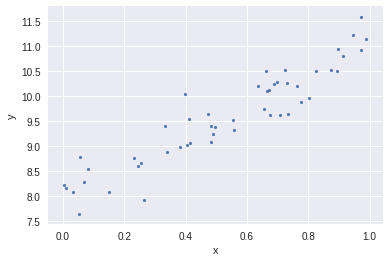

In [3]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y");

In [0]:
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()

In [5]:
y_hat = lin(10,5,x)
mse(y_hat, y)

4.648603008757235

In [0]:
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

In [7]:
mse_loss(10, 5, x, y)

4.648603008757235

In [8]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)
x.shape, y.shape

((10000,), (10000,))

In [0]:
x,y = V(x),V(y)

In [10]:
# Create random weights a and b, and wrap them in Variables.
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)
a,b

(Variable containing:
 -0.6863
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -1.0969
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [11]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    loss = mse_loss(a,b,x,y)
    if t % 1000 == 0: print(loss.data[0])
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are Tensors
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    
    # Zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()

120.71295166015625
0.9066709876060486
0.13721820712089539
0.1226956769824028
0.11517951637506485
0.10942673683166504
0.10500600934028625
0.10160885006189346
0.09899840503931046
0.09699228405952454


In [0]:
def gen_fake_data2(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, np.where(y>10, 1, 0).astype(np.float32)

In [0]:
x,y = gen_fake_data2(10000, 3., 8.)
x,y = V(x),V(y)

In [0]:
def nll(y_hat, y):
    y_hat = torch.clamp(y_hat, 1e-5, 1-1e-5)
    return (y*y_hat.log() + (1-y)*(1-y_hat).log()).mean()

In [0]:
a = V(np.random.randn(1), requires_grad=True)
b = V(np.random.randn(1), requires_grad=True)

In [16]:
learning_rate = 1e-2
for t in range(3000):
    p = (-lin(a,b,x)).exp()
    y_hat = 1/(1+p)
    loss = nll(y_hat,y)
    if t % 1000 == 0:
        print(loss.data[0], np.mean(to_np(y)==(to_np(y_hat)>0.5)))
#         print(y_hat)
    
    loss.backward()
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data
    a.grad.data.zero_()
    b.grad.data.zero_()

-1.5168941020965576 0.3355
-6.2285237312316895 0.3355
-7.646058559417725 0.3355


In [0]:
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3

In [0]:
x, y = gen_fake_data(50, 3., 8.)

In [19]:
a_guess,b_guess = -1., 1.
mse_loss(a_guess, b_guess, x, y)

83.65750051669785

In [0]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [21]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 20), interval=100)
ani